In [1]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [2]:
df = pd.read_csv("diabetes.csv")

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

# Holdout

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=45)

cart_model = DecisionTreeClassifier(random_state=17).fit(X_train, y_train)

In [4]:
# Test Error
y_pred = cart_model.predict(X_test)
y_prob = cart_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_prob)

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       154
           1       0.53      0.56      0.54        77

    accuracy                           0.69       231
   macro avg       0.65      0.66      0.65       231
weighted avg       0.69      0.69      0.69       231



0.6558441558441559

# Cross-validation


In [5]:
cart_model = DecisionTreeClassifier(random_state=17).fit(X, y)

cv_results = cross_validate(cart_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

In [6]:
cv_results['test_accuracy'].mean()

0.7058568882098294

In [7]:
cv_results['test_f1'].mean()

0.5710621194523633

In [8]:
cv_results['test_roc_auc'].mean()

0.6719440950384347

# Hyperparameter Optimization with GridSearchCV

In [9]:
cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

cart_best_grid = GridSearchCV(cart_model,
                              cart_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=1).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [10]:
cart_best_grid.best_params_

{'max_depth': 5, 'min_samples_split': 4}

In [11]:
cart_best_grid.best_score_

0.7500806383159324

# Final Model

In [12]:
cart_final = DecisionTreeClassifier(**cart_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(cart_final,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "f1", "roc_auc"])

In [13]:
cv_results['test_accuracy'].mean()

0.7500806383159324

In [14]:
cv_results['test_f1'].mean()

0.614625004082526

In [15]:
cv_results['test_roc_auc'].mean()

0.797796645702306

# Feature Importance

In [16]:
cart_final.feature_importances_

array([0.01129738, 0.49448119, 0.05065617, 0.        , 0.01497644,
       0.22221379, 0.06819923, 0.13817579])

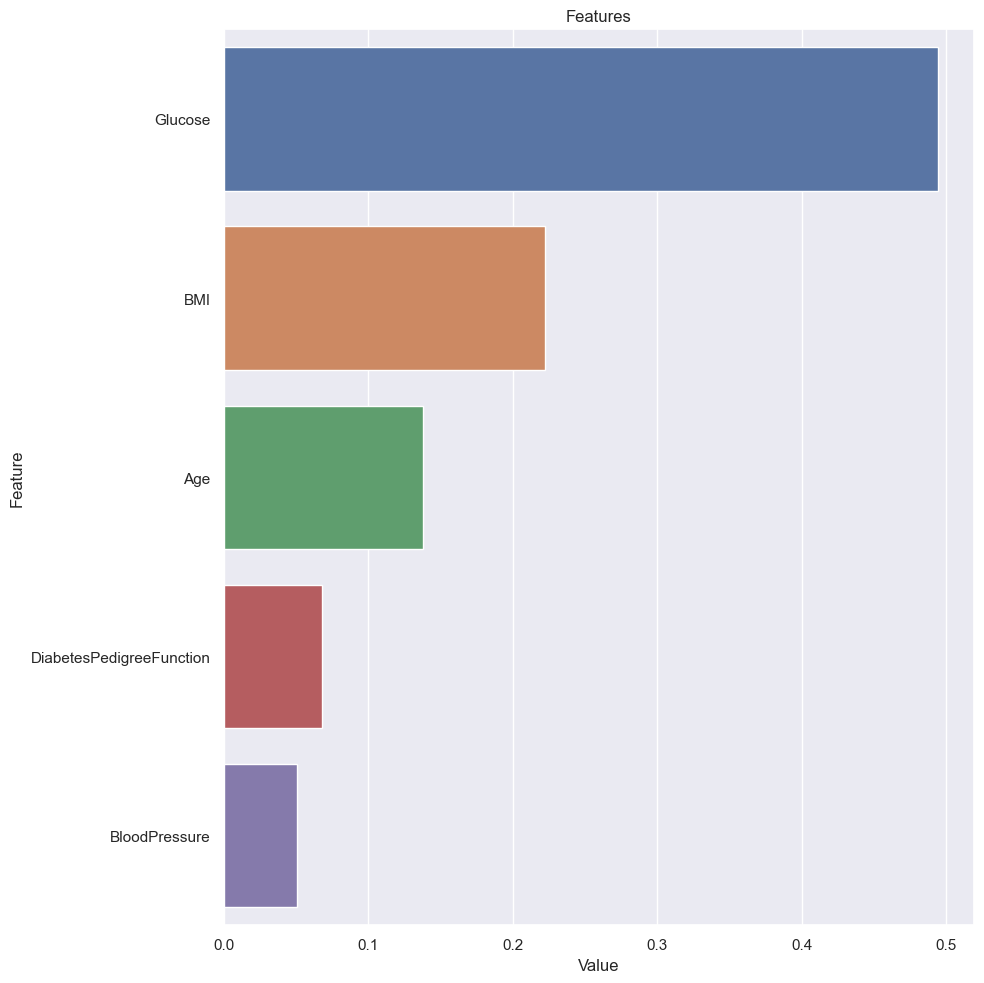

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()

plot_importance(cart_final, X, num=5)

# Analyzing Model Complexity with Learning Curves

In [18]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

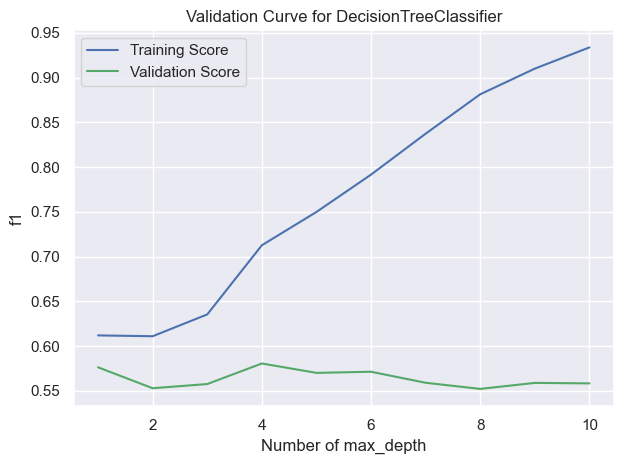

In [19]:
val_curve_params(cart_final, X, y, "max_depth", range(1, 11), scoring="f1")

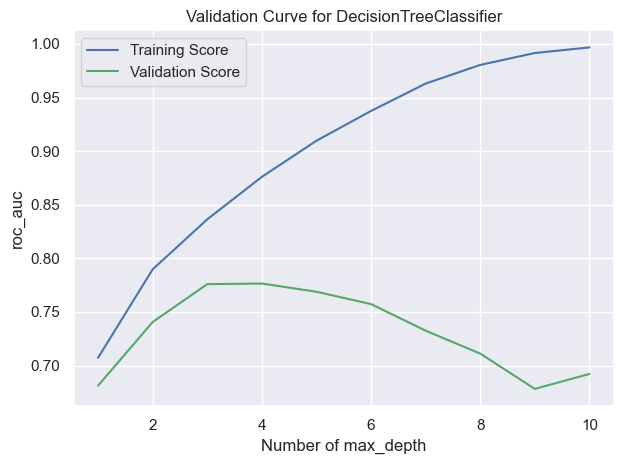

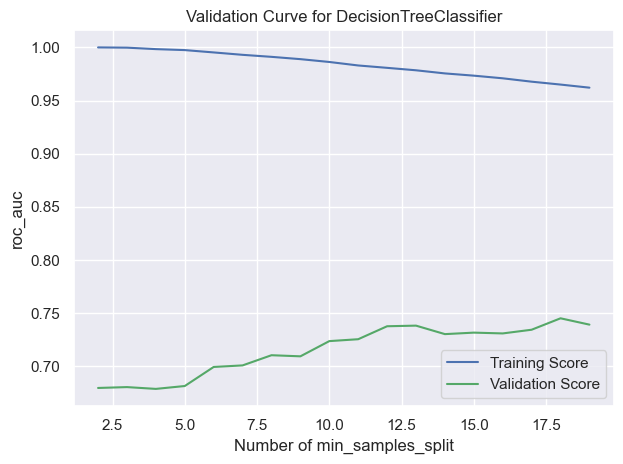

In [20]:
cart_val_params = [["max_depth", range(1, 11)], ["min_samples_split", range(2, 20)]]

for i in range(len(cart_val_params)):
    val_curve_params(cart_model, X, y, cart_val_params[i][0], cart_val_params[i][1])

# Saving and Loading Model

In [21]:
joblib.dump(cart_final, "cart_final.pkl")

['cart_final.pkl']

In [22]:
cart_model_from_disc = joblib.load("cart_final.pkl")

x = [12, 13, 20, 23, 4, 55, 12, 7]

cart_model_from_disc.predict(pd.DataFrame(x).T)

array([1], dtype=int64)